<b>Instructions</b>
1. You should have <i>\_project_root_dir\_/configs/users.csv</i> file. But this file is not allowed to be pushed to this project's GitHub repository. Please ask this script's developer(s) for the file. There is however a template <i>\_project_root_dir\_/configs/users_template.csv</i>.
2. You should have <i>\_project_root_dir\_/images/raw</i> containing image dataset. Images can be at max one subfolder level down to be detected by the script.
3. Run all blocks. Scroll to the bottom. The bottommost contains hyperparameters such as row index start. Below that block is the app display.
4. Input your username as assigned in <i>users.csv</i> which determines what labeling CSV file you are assigned to.
5. Continually label or skip images with appropriate inputs as asked in prompts. All inputs are case-insensitive.
6. To terminate and save changes, use <b>(s)</b> option. To terminate but cancel changes, use <b>(c)</b> option.
7. To repeat the app, just run the bottommost block. No need to repeat the others. Note: already labeled images in a current user's file are automatically skipped.
8. Changes apply to a user's assigned CSV file only.

In [4]:
import matplotlib.pyplot as plt
import os
import pandas as pd

from IPython.display import clear_output

In [5]:
class ImageClassUpdater:
    root_dir = ".."
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp']
    
    def __init__(self, statuses_csv="tracker\\tracker.csv", images_folder="images\\raw",
                 start_index=1):
        print(f"Starting Image Class Updater...")
        print(f"Statuses CSV: {statuses_csv}")
        print(f"Images folder: {images_folder}")
        print(f"Start index: {start_index}")

        self.statuses_csv = os.path.join(self.root_dir, statuses_csv)
        self.images_folder = os.path.join(self.root_dir, images_folder)
        self.current_index = start_index - 1
        self.users_config = os.path.join(self.root_dir, "configs\\users.csv")
        self.classes_config = os.path.join(self.root_dir, "configs\\pomelo_classes.csv")
        self.labeling_csv = None
        self.username = None
        self.images_data = None
        self.pomelo_classes = {}
        self.navigation_options = {
            "n": ("Next image (skip this)", self.handle_next_option, self.allow_next_option),
            "b": ("Back to previous", self.handle_back_option, self.allow_back_option),
            "j": ("Jump to index", self.handle_jump_option, None),
            "s": ("Save change/s and terminate", self.handle_save_terminate_option, None),
            "c": ("Cancel change/s and terminate", self.handle_cancel_terminate_option, None)
        }
        self.continue_prompt = True
        self.terminate = False
        
        self.validate_inputs()
        self.load_configs()
        self.load_images_data()
    
    def format_option(self, prompt, name):
        """Return formatted option string: ({prompt}) {name}"""
        return f"({prompt}) {name}"
    
    def validate_inputs(self):
        """Validate input parameters and files"""
        if self.current_index < 0:
            raise ValueError("Parameter start_index must be at least 1")
        
        if not os.path.exists(self.statuses_csv):
            raise FileNotFoundError(f"Statuses CSV file not found: {self.statuses_csv}")
        
        if not os.path.exists(self.images_folder):
            raise FileNotFoundError(f"Images folder not found: {self.images_folder}")
    
    def load_configs(self):
        """Load users and classes configuration"""
        # Load users config
        if not os.path.exists(self.users_config):
            raise FileNotFoundError(f"Users config file not found: {self.users_config}")
        
        users_df = pd.read_csv(self.users_config)
        self.prompt_username(users_df)
        
        # Load classes config
        if not os.path.exists(self.classes_config):
            raise FileNotFoundError(f"Classes config file not found: {self.classes_config}")
        
        classes_df = pd.read_csv(self.classes_config)
        self.pomelo_classes = {
            row['Name']: str(row.get('Included in Class Updater', 'FALSE')).upper() == 'TRUE'
            for _, row in classes_df.iterrows()
        }
    
    def prompt_username(self, users_df):
        """Simple synchronous username prompt that works in notebooks"""
        while True:
            username = input("Enter your username: ").strip()
            if not username:
                print("Username cannot be empty. Please try again.\n")
                continue
            
            # Case-insensitive matching
            matching_users = users_df[users_df['Name'].str.lower() == username.lower()]
            
            if not matching_users.empty:
                self.username = matching_users.iloc[0]['Name']
                self.labeling_csv = os.path.join(self.root_dir, matching_users.iloc[0]['Labeling File Path'])
                print(f"Welcome, {self.username}!")
                print(f"Labeling through file: {self.labeling_csv}\n")
                
                # Check file permissions
                if not os.path.exists(self.labeling_csv):
                    raise FileNotFoundError(f"Labeling CSV file not found: {self.labeling_csv}")
                
                try:
                    with open(self.labeling_csv, 'r+') as f:
                        pass
                except PermissionError:
                    raise PermissionError(f"No write permission for labeling CSV: {self.labeling_csv}. Please close the file if it is open in another program.")
                
                break
            else:
                print("Invalid username. Please try again.\n")
    
    def validate_csv_files(self):
        """Validate that statuses and labeling CSV files have matching structure"""
        statuses_df = pd.read_csv(self.statuses_csv)
        labeling_df = pd.read_csv(self.labeling_csv)
        
        # Check row count (excluding headers)
        if len(statuses_df) != len(labeling_df):
            raise ValueError(f"Row count mismatch: statuses CSV has {len(statuses_df)} rows, labeling CSV has {len(labeling_df)} rows")
        
        # Check if Name columns match exactly
        if not statuses_df['Name'].equals(labeling_df['Name']):
            raise ValueError("Name columns in statuses and labeling CSV files do not match")
        
        # Validate start_index bounds
        if self.current_index > len(labeling_df) - 1:
            raise ValueError(f"Parameter start_index {self.current_index} exceeds maximum row index {len(labeling_df)}")
        
        return statuses_df, labeling_df
    
    def find_image_file(self, image_name):
        """Find image file in images folder (direct and one subfolder level down)"""
        # Search in root images folder
        for ext in self.image_extensions:
            file_path = os.path.join(self.images_folder, image_name + ext)
            if os.path.exists(file_path):
                return file_path
        
        # Search in subfolders (one level down)
        for subdir in os.listdir(self.images_folder):
            subdir_path = os.path.join(self.images_folder, subdir)
            if os.path.isdir(subdir_path):
                for ext in self.image_extensions:
                    file_path = os.path.join(subdir_path, image_name + ext)
                    if os.path.exists(file_path):
                        return file_path
        
        return None
    
    def load_images_data(self):
        """Load tuple of image data dictionaries"""
        print("Loading images data...")
        statuses_df, labeling_df = self.validate_csv_files()
        
        images_data = []
        for index in range(0, len(statuses_df)):
            image_name = statuses_df.iloc[index]['Name']
            status = statuses_df.iloc[index]['Status'] if 'Status' in statuses_df.columns else ''
            class_name = labeling_df.iloc[index]['Class']
            
            file_path = self.find_image_file(image_name)
            
            images_data.append({
                'image_name': image_name,
                'file_path': file_path,
                'status': status,
                'original_class': class_name,
                'assigned_class': class_name,
                'df_index': index
            })
        
        self.images_data = tuple(images_data)
        print(f"Prepared {len(images_data)} images for processing")
    
    def should_skip_image(self, image_data):
        """Check if image should be skipped based on status and class conditions"""
        image_name = image_data['image_name']
        assigned_class = image_data['assigned_class']
        status = image_data['status']
        if status == 'Unusable':
            print(f"Skipping '{image_name}' - Unusable")
            return True
        if assigned_class not in self.pomelo_classes:
            raise ValueError(f"Invalid class '{assigned_class}' for image '{image_name}'")
        return False
    
    def display_image_info(self, image_data):
        """Display image information and image itself"""
        row_index = image_data['df_index'] + 1
        original_class = image_data['original_class']
        assigned_class = image_data['assigned_class']
        print(f"Row {row_index}/{len(self.images_data)}")
        print(f"Image Name: {image_data['image_name']}")
        print(f"Original Class: {original_class}")
        print(f"New Class: {"?" if assigned_class == original_class else assigned_class + " (updated)"}")
        
        if image_data['file_path'] and os.path.exists(image_data['file_path']):
            img = plt.imread(image_data['file_path'])
            plt.figure(figsize=(8, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        else:
            print(f"Image not found: {image_data['file_path']}")
    
    def print_options(self, valid_classes):
        print("\nLabeling Options:")
        for prompt, name in enumerate(valid_classes, 1):
            print(self.format_option(prompt, name))
        if self.allow_remove_label_option():
            print(self.format_option("r", "Remove label (set to Unlabeled)"))
        print("Navigation Options:")
        for prompt, prompt_data in self.navigation_options.items():
            name, _, allow_option = prompt_data
            if allow_option != None and not allow_option():
                continue
            print(self.format_option(prompt, name))

    def handle_class_selection(self, choice, valid_classes, image_data, labeling_df):
        """Handle class selection option"""
        assigned_class = valid_classes[int(choice) - 1]
        confirmation = input(f"Change to '{assigned_class}'? (y/n): ").lower()
        if confirmation == 'y':
            image_data['assigned_class'] = assigned_class
            labeling_df.at[image_data['df_index'], 'Class'] = assigned_class
            self.continue_prompt = False
            print(f"Updated to {assigned_class}")
        elif confirmation == 'n':
            return
        else:
            print("Please choose either in (y/n)")
            self.handle_class_selection(choice, valid_classes, image_data, labeling_df)
    
    def allow_remove_label_option(self):
        image_data = self.images_data[self.current_index]
        return image_data['assigned_class'] != next(iter(self.pomelo_classes))
    
    def handle_next_option(self, _):
        """Handle next option"""
        self.current_index += 1
        self.continue_prompt = False
        print("Skipped")
    
    def allow_next_option(self):
        return self.current_index < len(self.images_data) - 1

    def handle_back_option(self, _):
        """Handle back to previous option"""
        print("Going back to previous image...")
        self.current_index -= 1
        self.continue_prompt = False
    
    def allow_back_option(self):
        return self.current_index > 0

    def handle_jump_option(self, _):
        """Handle jump to index option"""
        images_len = len(self.images_data)
        jump_index = int(input("\nSelect index: ").strip())
        if jump_index < 1 or jump_index > images_len:
            print(f"Jump index must be between 1-{images_len}")
            return
        self.current_index = jump_index - 1
        self.continue_prompt = False
        print(f"Jumping to image {jump_index}...")
    
    def handle_save_terminate_option(self, labeling_df):
        """Handle save and terminate option"""
        confirmation = input("Save changes and terminate? (y/n): ").lower()
        if confirmation == 'y':
            updated_count = self.get_updated_count()
            if updated_count > 0:
                labeling_df.to_csv(self.labeling_csv, index=False)
                for image_data in self.images_data:
                    image_data['original_class'] = image_data['assigned_class']
                print(f"Saved {updated_count} update{"s" if updated_count > 1 else ""} to: {self.labeling_csv}")
            else:
                print("No changes to save")
            self.continue_prompt = False
            self.terminate = True
        elif confirmation == 'n':
            return
        else:
            print("Please choose either in (y/n)")
            self.handle_save_terminate_option(labeling_df)
    
    def handle_cancel_terminate_option(self, _):
        """Handle cancel and terminate option"""
        confirmation = input("Cancel all changes and terminate? (y/n): ").lower()
        if confirmation == 'y':
            updated_count = self.get_updated_count()
            if updated_count > 0:
                for image_data in self.images_data:
                    image_data['assigned_class'] = image_data['original_class']
                print(f"Cancelled {updated_count} unsaved change{"s" if updated_count > 1 else ""}")
            else:
                print("No changes to cancel")
            self.continue_prompt = False
            self.terminate = True
        elif confirmation == 'n':
            return
        else:
            print("Please choose either in (y/n)")
            self.handle_cancel_terminate_option(_)
    
    def get_updated_count(self):
        """Get amount of rows updated"""
        return len([image_data for image_data in self.images_data if image_data["original_class"] != image_data["assigned_class"]])

    def run_updater(self):
        """Main method to run the image class updater"""
        if not self.images_data:
            print("No images to process.")
            return

        labeling_df = pd.read_csv(self.labeling_csv)
        valid_classes = [cls for cls, included in self.pomelo_classes.items() if included]
        unlabeled_class = [next(iter(self.pomelo_classes))]
        self.terminate = False
        
        while self.images_data[self.current_index]['assigned_class'] in valid_classes:
            self.current_index += 1

        while 0 <= self.current_index < len(self.images_data) and not self.terminate:
            clear_output(wait=True)
            image_data = self.images_data[self.current_index]
            if self.should_skip_image(image_data):
                self.current_index += 1
                continue
            self.display_image_info(image_data)
            self.print_options(valid_classes)
            self.continue_prompt = True
            while self.continue_prompt:
                choice = input("\nSelect option: ").strip().lower()
                is_valid_class_choice = choice.isdigit() and 1 <= int(choice) <= len(valid_classes)
                is_remove_label_choice = choice == "r" and self.allow_remove_label_option()
                if is_valid_class_choice or is_remove_label_choice:
                    self.handle_class_selection(
                        choice if is_valid_class_choice else 1,
                        valid_classes if is_valid_class_choice else unlabeled_class,
                        image_data, labeling_df
                    )
                    self.current_index += 1
                    while self.images_data[self.current_index]['assigned_class'] in valid_classes:
                        self.current_index += 1
                elif choice in self.navigation_options:
                    _, handle_option, allow_option = self.navigation_options[choice]
                    if allow_option != None and not allow_option():
                        print("Invalid option")
                        continue
                    handle_option(labeling_df)
                else:
                    print("Invalid option")
            
        if self.terminate:
            return
        print("\nNo more image/s to process.")
        updated_count = self.get_updated_count()
        if updated_count > 0:
            labeling_df.to_csv(self.labeling_csv, index=False)
            print(f"Completed! Saved {updated_count} updates to: {self.labeling_csv}")
        else:
            print("No changes made")

Row 3/1557
Image Name: IMG20250703082806
Original Class: Unlabeled
New Class: ?


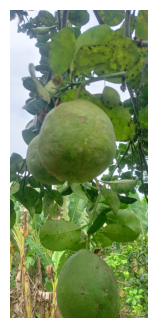


Labeling Options:
(1) Anthracnose
(2) Borer
(3) Canker
(4) Healthy
(5) Mites
(6) Multiple
Navigation Options:
(n) Next image (skip this)
(b) Back to previous
(j) Jump to index
(s) Save change/s and terminate
(c) Cancel change/s and terminate
Saved 2 updates to: ..\tracker\class_updates_1.csv


In [6]:
def main():
    statuses_csv = "tracker\\tracker.csv"
    images_folder = "images\\raw"
    start_index = 1
    
    updater = ImageClassUpdater(statuses_csv, images_folder, start_index)
    updater.run_updater()

if __name__ == "__main__":
    main()